                                                            AMSS-CSC
<p align="center">
                                                    <img src="./logo_ens.png">
</p>

<div style="text-align: center;">
    <H1>Techniques et outils pour la preuve de concepts</H1>
    Alberic Junior DASSI FEUSSOUO
</div>

 <H3><i> Machine learning-based approach for online fault Diagnosis of Discrete Event System (Saddem et al. - 2022 )</H3> 

# 4. Modèle de l'algorithme d'apprentissage automatique pour le diagnostic
Dans cette partie, nous allons construire l'algorithme de réseaux de neurones récurrents pour le diagnostic, lui fournir les données formatées dans <a  href ="./preparation_des_donnees.ipynb"> la section précédente</a>, l'entrainer, le tester et évaluer ses performances. <br>
Nous rappelons que notre modèle est un classifieur multi-classes car au total, 8 classes sont considérées (C0 à C7). L’algorithme prend en entrée les données du système (au bon format) et renvoie en sortie sortie une distribution de probabilité sur les classes (encodées), activée grâce à la fonction <i><b>softmax</b></i>. L'architecture du modèle est visible sur la figure ci-dessous. qu’on peut le voir sur la figure ci-dessous (<i>section 3.6 de l’article</i>).<br>
<div style="text-align: center;">
    <img src="./architecture_modele_RNN.png">
</div> <br>

# <H3> 4.1. Framework et bibliothèques nécessaires
Un framework ou cadre de programmation est un environnement de travail qui permet de faciliter la
création de modèles de Machine Learning en mettant à disposition différents systèmes avec différentes
bibliothèques. L'article ne fait mention du Framework utilisé. Cependant, il s’agit d’une approche basée sur les réseaux de neurones récurrents avec LSTM (pour le traitement des données séquentielles), et l’utilisation des fonctions Softmax, Categorical Cross-Entropy, nous permettent de nous pencher sur les Framework TensorFlow et PyTorch. Pour notre travail, nous avons utilisé TensorFlow et son API keras. <br>
De plus, afin d'évaluer les performances du modèle, nous avons utilisé les métriques de l'outil scikit-learn (pour dresser la matrice de confusion par exemple)

In [5]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# <H3>4.2.  Modèle
Notre modèle de Machine Learning est concu de sorte a respecter l'architecture decrite a la section 3.6 de l'article. <br>
* Attributs : Nombre de pas de temps, Nombre de classes, nombre de composante par pas de temps
* Methodes : COnstruction de l'architecture du modele, la quantification de l'erreur du modele, l'entrainement, le test et l'evaluation sur les differents jeux de donnees, 

In [2]:
class ModelML:
    
    #Modèle RNN-LSTM basé sur la section 3.6
    
    def __init__(self, n_steps, n_features, n_classes):
        #Constructeur
        #Paramètres: 
        #n_steps (int)  : Nombre de pas de temps (N=50 dans l'article)
        #n_features(int): Nombre de features par pas de temps
        #n_classes(int) : Nombre de classes (8 : C0 à C7))

        self.n_steps = n_steps
        self.n_features = n_features
        self.n_classes = n_classes
        self.model = None
        self.history = None
        
        print(f"Initialisation du modèle LSTM")
        print(f"  - Pas de temps (N) : {n_steps}")
        print(f"  - Features : {n_features}")
        print(f"  - Classes : {n_classes}")
    
    def build_model(self, lstm_units=[128, 64], dropout=0.3):
        
        #La construction de l'architecture RNN-LSTM est inspirée 
        #de la Figure 3 de l'article :Input-LSTM layers-Dense-Softmax (8 neurones)
        #Paramètres:
        #lstm_units (list) : Nombre de neurones par couche LSTM
        #dropout(float)    : c'est un taux qui permet d'éviter le surapprentissage

        print(f"\nConstruction du modèle")
        print(f" - Couches LSTM : {lstm_units}")
        print(f" - Dropout : {dropout}")
        
        model = keras.Sequential([
            # Couche d'entrée
            layers.Input(shape=(self.n_steps, self.n_features)),
            
            # Première couche LSTM (retourne les séquences)
            layers.LSTM(lstm_units[0], return_sequences=True, name='LSTM_1'),
            layers.Dropout(dropout),
            
            # Deuxième couche LSTM
            layers.LSTM(lstm_units[1], return_sequences=False, name='LSTM_2'),
            layers.Dropout(dropout),
            
            # Couche Dense intermédiaire
            #ReLU = Rectified Linear Unit
            #Permet de donner a la couche Dense la capacité d'apprendre des relations non linéaires
            layers.Dense(32, activation='relu', name='Dense_1'),
            layers.Dropout(dropout/2),
           
            # Couche de sortie avec Softmax (8 neurones pour 8 classes)
            layers.Dense(self.n_classes, activation='softmax', name='Output')
        ])
        
        self.model = model
        
        print("\n" + "="*70)
        print("ARCHITECTURE DU MODÈLE")
        print("="*70)
        self.model.summary()
        
        return model
    
    def compile_model(self, learning_rate=0.001):
        #Cette fonction permet de quantifier l'erreur entre les predictions du modele et les vraies classes
        # grace a "Categorical Cross-Entropy (CCE)" tel que decrit dans l'article (section 4.2)
        
        #Learning rate = taux d'apprentissage
        #C'est un hyperparametre qui definit la taille du pas que fait le modele lors de la mise a jour de ses poids.
        


        print(f"\nCompilation du modèle")
        print(f" - Fonction de perte : Categorical Crossentropy (CCE)")
        print(f" - Optimiseur : Adam")
        print(f" - Learning rate : {learning_rate}")
        #Adam = Adaptive Moment Estimation.
        #algorithme d’optimisation conçu pour mettre à jour les poids d’un réseau neuronal 
        #de manière plus intelligente que la descente de gradient classique.

        self.model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
            loss='sparse_categorical_crossentropy',  # CCE pour labels entiers
            metrics=['accuracy']
        )
        
        print(" Modèle compilé")
    
    def train(self, X_train, y_train, X_val, y_val, 
              epochs=100, batch_size=32, verbose=1):
        
        #Cette fonction permet l'entraînement du modèle avec validation
        
        #La section 3.2 indique l'usage du "cross-validation"
        #Simple validation holdout
        
        print("\n" + "="*70)
        print("ENTRAÎNEMENT DU MODÈLE")
        print("="*70)
        print(f"Epochs : {epochs}")
        print(f"Batch size : {batch_size}")
        print(f"Échantillons d'entraînement : {len(X_train)}")
        print(f"Échantillons de validation : {len(X_val)}")
        
        # Callbacks pour améliorer l'entraînement
        callbacks = [
            # Arrêt précoce si pas d'amélioration
            EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True,
                verbose=1
            ),
            
            # Réduction du learning rate
            ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-7,
                verbose=1
            ),
            
            # Sauvegarde du meilleur modèle
            ModelCheckpoint(
                'best_model.keras',
                monitor='val_accuracy',
                save_best_only=True,
                verbose=1
            )
        ]
        
        # Entraînement
        self.history = self.model.fit(
            X_train, y_train,
            validation_data=(X_val, y_val),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=verbose
        )
        
        print("\n✓ Entraînement terminé")
        
        return self.history
    
    def plot_training_history(self):

        #Visualise l'historique d'entraînement
        # Correspond aux Figures 8 et 9 de l'article
        if self.history is None:
            print("Aucun historique d'entraînement disponible")
            return
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
        
        # Graphique 1 : Loss (fonction d'erreur)
        # Figure 8 de l'article : "Evolution of the error function"
        ax1.plot(self.history.history['loss'], label='Train Loss', linewidth=2)
        ax1.plot(self.history.history['val_loss'], label='Validation Loss', linewidth=2)
        ax1.set_xlabel('Epoch', fontsize=12)
        ax1.set_ylabel('Loss (CCE)', fontsize=12)
        ax1.set_title('Évolution de la fonction d\'erreur', fontsize=14, fontweight='bold')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Graphique 2 : Accuracy
        # Figure 9 de l'article : "Evolution of the average accuracy"
        ax2.plot(self.history.history['accuracy'], label='Train Accuracy', linewidth=2)
        ax2.plot(self.history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
        ax2.set_xlabel('Epoch', fontsize=12)
        ax2.set_ylabel('Accuracy', fontsize=12)
        ax2.set_title('Évolution de l\'accuracy moyenne', fontsize=14, fontweight='bold')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        # Afficher les meilleurs résultats
        best_epoch = np.argmax(self.history.history['val_accuracy'])
        print("\n" + "="*70)
        print("MEILLEURS RÉSULTATS")
        print("="*70)
        print(f"Meilleur epoch : {best_epoch + 1}")
        print(f"Train Accuracy : {self.history.history['accuracy'][best_epoch]:.4f}")
        print(f"Val Accuracy : {self.history.history['val_accuracy'][best_epoch]:.4f}")
        print(f"Train Loss : {self.history.history['loss'][best_epoch]:.4f}")
        print(f"Val Loss : {self.history.history['val_loss'][best_epoch]:.4f}")
    
    def evaluate(self, X_test, y_test, class_names):

        # Évaluation sur le jeu de test
        print("\n" + "="*70)
        print("ÉVALUATION SUR LE JEU DE TEST")
        print("="*70)
        
        # Prédictions
        y_pred_probs = self.model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_pred_probs, axis=1)
        
        # Accuracy globale
        test_loss, test_acc = self.model.evaluate(X_test, y_test, verbose=0)
        print(f"\nTest Loss : {test_loss:.4f}")
        print(f"Test Accuracy : {test_acc:.4f}")
        
        # Rapport de classification détaillé
        print("\n" + "="*70)
        print("RAPPORT DE CLASSIFICATION")
        print("="*70)
        print(classification_report(y_test, y_pred, target_names=class_names))
        
        return y_pred, y_pred_probs
    
    def plot_confusion_matrix(self, y_test, y_pred, class_names):
        """
        Matrice de confusion
        Figure 10 de l'article : "The average of normalized multi-class confusion matrix"
        """
        # Calculer la matrice de confusion
        cm = confusion_matrix(y_test, y_pred)
        cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Visualisation
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                    xticklabels=class_names, yticklabels=class_names,
                    cbar_kws={'label': 'Proportion'})
        plt.xlabel('Classe prédite', fontsize=12)
        plt.ylabel('Classe réelle', fontsize=12)
        plt.title('Matrice de confusion normalisée', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        return cm, cm_normalized
    
    def calculate_metrics(self, cm):

        #On calcule les métriques par classe (Section 3.6)
        
        #Precision_i = TP_i / (TP_i + FP_i)
        #Recall_i = TP_i / (TP_i + FN_i)
        n_classes = cm.shape[0]
        
        precision = []
        recall = []
        
        for i in range(n_classes):
            TP = cm[i, i]
            FP = cm[:, i].sum() - TP
            FN = cm[i, :].sum() - TP
            
            prec = TP / (TP + FP) if (TP + FP) > 0 else 0
            rec = TP / (TP + FN) if (TP + FN) > 0 else 0
            
            precision.append(prec)
            recall.append(rec)
        
        return precision, recall
    
    def save_model(self, filepath='lstm_diagnostic_model.keras'):

        #Sauvegarde du modèle entraîné

        self.model.save(filepath)
        print(f"\n Modèle sauvegardé : {filepath}")
    
    def load_model(self, filepath='lstm_diagnostic_model.keras'):

        #Charge un modèle pré-entraîné
        self.model = keras.models.load_model(filepath)
        print(f" Modèle chargé : {filepath}")


# <H3> 4.3. Instanciation du modèle, entrainement, test validation et évaluation des performances

MODÈLE RNN-LSTM POUR LE DIAGNOSTIC DE DÉFAUTS

Chargement des données...
 Données chargées
  X_train shape : (690, 50, 4)
  y_train shape : (690,)
Initialisation du modèle LSTM
  - Pas de temps (N) : 50
  - Features : 4
  - Classes : 8

Construction du modèle
 - Couches LSTM : [128, 64]
 - Dropout : 0.3

ARCHITECTURE DU MODÈLE


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ LSTM_1 (LSTM)                        │ (None, 50, 128)             │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ LSTM_2 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Output (Dense)                       │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 119,848 (468.16 KB)

 Trainable params: 119,848 (468.16 KB)

 Non-trainable params: 0 (0.00 B)


Compilation du modèle
 - Fonction de perte : Categorical Crossentropy (CCE)
 - Optimiseur : Adam
 - Learning rate : 0.001
 Modèle compilé

ENTRAÎNEMENT DU MODÈLE
Epochs : 100
Batch size : 32
Échantillons d'entraînement : 690
Échantillons de validation : 230
Epoch 1/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4317 - loss: 1.8973
Epoch 1: val_accuracy improved from None to 0.59565, saving model to best_model.keras

Epoch 1: finished saving model to best_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - accuracy: 0.5406 - loss: 1.6996 - val_accuracy: 0.5957 - val_loss: 1.4093 - learning_rate: 0.0010
Epoch 2/100
21/22 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5934 - loss: 1.3923
Epoch 2: val_accuracy improved from 0.59565 to 0.67391, saving model to best_model.keras

Epoch 2: finished saving model to best_model.keras
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.6101 - loss: 1.3674 - val_accuracy: 0.6739 - val_loss: 1.2439 - learning_rate: 0.0010
Epoch 3/10

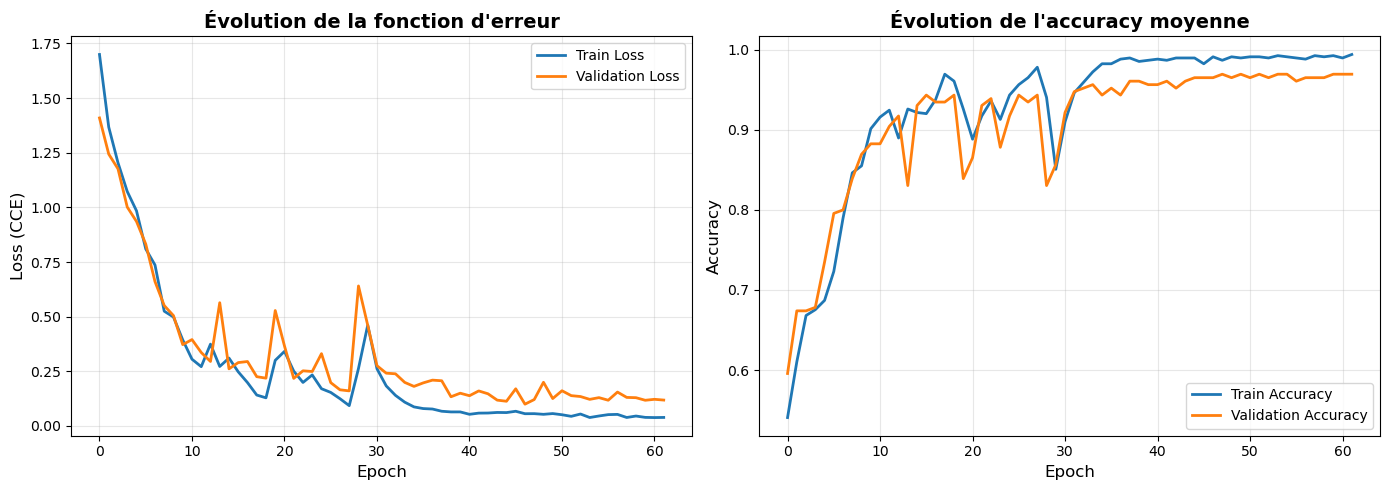


MEILLEURS RÉSULTATS
Meilleur epoch : 48
Train Accuracy : 0.9870
Val Accuracy : 0.9696
Train Loss : 0.0564
Val Loss : 0.1210

ÉVALUATION SUR LE JEU DE TEST

Test Loss : 0.0428
Test Accuracy : 0.9913

RAPPORT DE CLASSIFICATION
              precision    recall  f1-score   support

          C0       0.99      1.00      0.99       137
          C1       1.00      0.87      0.93        15
          C2       1.00      1.00      1.00        13
          C3       1.00      1.00      1.00        12
          C4       1.00      1.00      1.00        13
          C5       1.00      1.00      1.00        13
          C6       1.00      1.00      1.00        14
          C7       1.00      1.00      1.00        14

    accuracy                           0.99       231
   macro avg       1.00      0.98      0.99       231
weighted avg       0.99      0.99      0.99       231



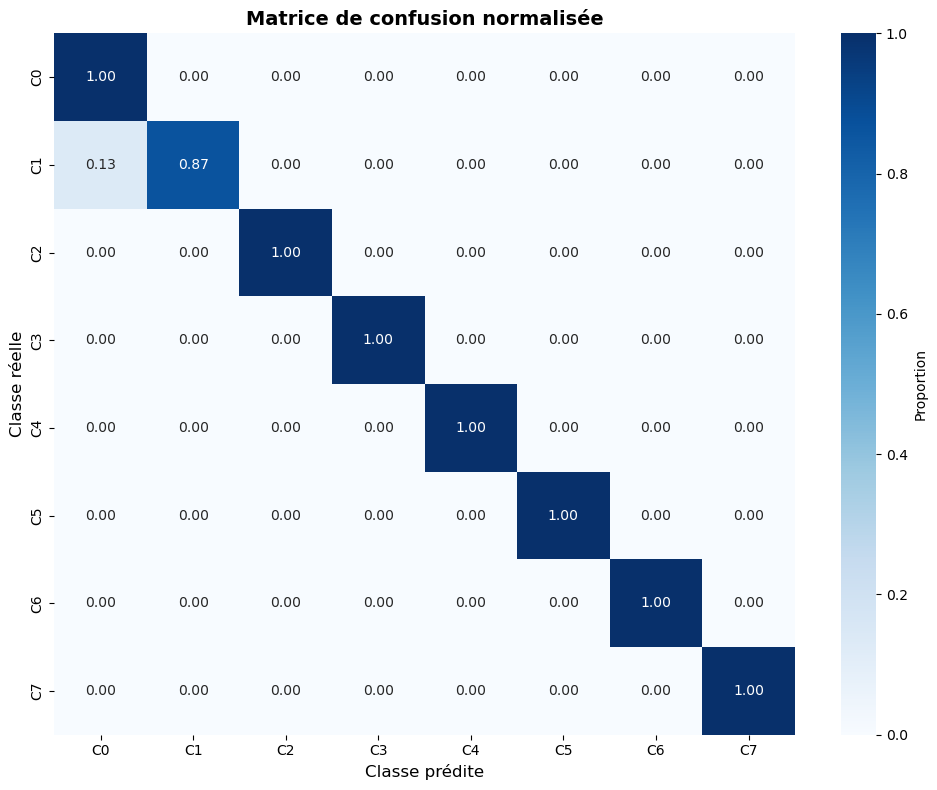


MÉTRIQUES PAR CLASSE
Classe     Precision    Recall      
-----------------------------------
C0         0.9856       1.0000      
C1         1.0000       0.8667      
C2         1.0000       1.0000      
C3         1.0000       1.0000      
C4         1.0000       1.0000      
C5         1.0000       1.0000      
C6         1.0000       1.0000      
C7         1.0000       1.0000      

 Modèle sauvegardé : lstm_diagnostic_model.keras

ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS !


In [3]:
if __name__ == "__main__":
    print("="*70)
    print("MODÈLE RNN-LSTM POUR LE DIAGNOSTIC DE DÉFAUTS")
    print("="*70)
    
    # 1. On charge les données préparées
    print("\nChargement des données...")
    data = np.load('prepared_data.npz')
    X_train = data['X_train']
    X_val = data['X_val']
    X_test = data['X_test']
    y_train = data['y_train']
    y_val = data['y_val']
    y_test = data['y_test']
    
    print(f" Données chargées")
    print(f"  X_train shape : {X_train.shape}")
    print(f"  y_train shape : {y_train.shape}")
    
    # 2. On crée et on construit le modèle
    n_steps = X_train.shape[1]  # 50
    n_features = X_train.shape[2]  # 4 (avec durées) ou 3 (sans)
    n_classes = len(np.unique(y_train))  # 8
    
    model = ModelML(n_steps, n_features, n_classes)
    model.build_model(lstm_units=[128, 64], dropout=0.3)
    model.compile_model(learning_rate=0.001)
    
    # 3. Entraînement
    history = model.train(
        X_train, y_train,
        X_val, y_val,
        epochs=100,
        batch_size=32,
        verbose=1
    )
    
    # 4. On visualise l'historique d'entraînement
    model.plot_training_history()
    
    # 5. Évaluer sur le jeu de test
    class_names = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
    y_pred, y_pred_probs = model.evaluate(X_test, y_test, class_names)
    
    # 6. Matrice de confusion
    cm, cm_normalized = model.plot_confusion_matrix(y_test, y_pred, class_names)
    
    # 7. Métriques par classe
    precision, recall = model.calculate_metrics(cm)
    
    print("\n" + "="*70)
    print("MÉTRIQUES PAR CLASSE")
    print("="*70)
    print(f"{'Classe':<10} {'Precision':<12} {'Recall':<12}")
    print("-" * 35)
    for i, name in enumerate(class_names):
        print(f"{name:<10} {precision[i]:<12.4f} {recall[i]:<12.4f}")
    
    # 8. Sauvegarder le modèle
    model.save_model('lstm_diagnostic_model.keras')
    
    print("\n" + "="*70)
    print("ENTRAÎNEMENT TERMINÉ AVEC SUCCÈS !")
    print("="*70)